In [1]:
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}  
from matplotlib import cm
import scipy as sp

from sympy import Symbol
from sympy.solvers import solve

from math import floor

# 1)
## a)

In [2]:
def f(x,y,a,r):
    return (a+1)*y**2*np.cos(x*y)+2*r*(np.sin(x*y)+x*y*np.cos(x*y))+r**2*x**2*np.cos(x*y)

def g(x,y):
    return np.cos(x*y)

In [3]:
def plot_solution(X, Y, U, txt='Solution', angle = 30, image_name = None):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(X, Y, U, cmap=cm.coolwarm)
    ax.view_init(azim=angle)              # Rotate the figure
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(txt);
    plt.tight_layout()
    #ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    if not image_name is None:
        plt.savefig(image_name)


In [4]:
def heat_eq_solver(f,g, M, a,r = 2):
    assert M > 2
    
    h = 1/M

    x = np.linspace(0,1, M+1)
    y = np.linspace(0,2, M+1)

    U = np.zeros((M+1,M+1))
    bn = np.zeros((M-1,M-1))

    main_diag = 2*(a+1)*np.ones((M-1)**2)
    off_diag = -a*np.ones((M-1)**2-1)
    off_diag[np.arange(1,M-1)*(M-1)-1] = 0
    off_diag2 = -np.ones((M-1)*(M-2)-1)
    off_diag2[np.arange(1,M-2)*(M-1)-1] = 0
    A = sp.sparse.diags([off_diag2,off_diag,main_diag,off_diag,off_diag2], [-M,-1,0,1,M])

    U[0,:] = g(x,y[0])
    U[-1,:] = g(x,y[-1])
    U[:,0] = g(x[0],y)
    U[:,-1] = g(x[-1],y)
    
    xx,yy = np.meshgrid(x[1:-1],y[1:-1])
    
    bn += f(xx,yy,a,r)*h**2

    bn[0,1:-1] += U[0,1:-3]
    bn[-1,1:-1] += U[-1,3:-1]

    bn[1:-1,0] += (a*U[2:-2,0] + U[1:-3,0])
    bn[1:-1,-1] += (a*U[2:-2,-1] + U[3:-1,-1])

    bn[0,0] += (a*U[1,0] + U[0,0])
    bn[-1,0] += (a*U[-2,0] + U[-3,0] + U[-1,2])
    bn[0,-1] += (a*U[1,-1] + U[0,-3] + U[2,-1])
    bn[-1,-1] += (a*U[-2,-1] + U[-1,-1])
    
    #U[1:-1,1:-1] = np.linalg.solve(A,bn.reshape((M-1)**2)).reshape((M-1,M-1))
    U[1:-1,1:-1] = sp.sparse.linalg.spsolve(sp.sparse.csr_matrix(A),bn.reshape((M-1)**2)).reshape((M-1,M-1))
    
    return x,y,U

In [14]:
x,y,U = heat_eq_solver(f,g,M = 500, a = 1)

xx,yy = np.meshgrid(x,y)

u_ex = g(xx,yy)


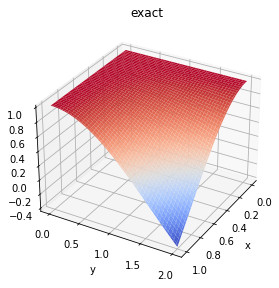

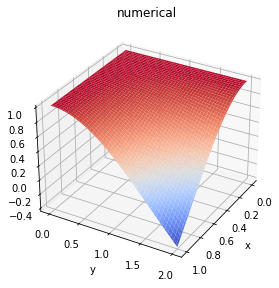

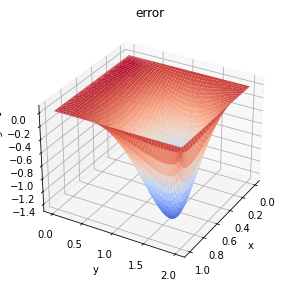

1.481156369387282e-06


In [15]:
plot_solution(xx,yy,u_ex, txt = "exact", image_name= 'exact1')
plt.show()

plot_solution(xx,yy,U, txt = "numerical")
plt.show()

plot_solution(xx,yy,u_ex-U, txt = "error")
plt.show()

print(np.max(np.abs((u_ex-U)[:-1,:])))


## c)

In [7]:
def convergence(f_ex1,u_ex1,M,a, r = 2 ,solver=heat_eq_solver): 
    P = 5
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    for p in range(P):
        x, y, U = solver(f_ex1,u_ex1,M, a, r)
        xx,yy = np.meshgrid(x,y)
        Eh = u_ex1(xx,yy)-U
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = int(M*2)
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]

    return Hconv, Econv, order

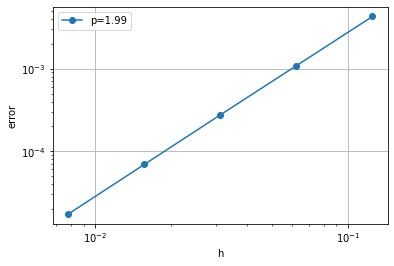

In [8]:
M = 8
a = 2

H, E, p = convergence(f,g,M,a)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()

## d)

In [9]:
def heat_eq_solver_general(f,g, M, a,r = np.pi):
    assert M > 3
    
    h = 1/M
    k = abs(r)*h

    N = floor(2/k)+1

    x = np.linspace(0,1, M+1)
    y = np.linspace(0,N*k,N+1)
    
    U = np.zeros((N+1,M+1))
    bn = np.zeros((N-1,M-1))
    
    main_diag = 2*(a+1)*np.ones((M-1)*(N-1))
    off_diag = -a*np.ones((M-1)*(N-1)-1)
    off_diag[np.arange(1,N-1)*(M-1)-1] = 0

    if r > 0:
        off_diag2 = -np.ones((M-1)*(N-2)-1)
        off_diag2[np.arange(1,N-2)*(M-1)-1] = 0
        A = sp.sparse.diags([off_diag2,off_diag,main_diag,off_diag,off_diag2], [-M,-1,0,1,M])
    elif r < 0:
        off_diag2 = -np.ones((M-1)*(N-2)+1)
        off_diag2[np.arange(N-1)*(M-1)] = 0
        A = sp.sparse.diags([off_diag2,off_diag,main_diag,off_diag,off_diag2], [-M+2,-1,0,1,M-2])
    
    
    U[0,:] = g(x,y[0])
    U[:,0] = g(x[0],y)
    U[:,-1] = g(x[-1],y)
    U[-1,:] = g(x,2)
    
    xx,yy = np.meshgrid(x[1:-1],y[1:-1])
    
    bn += f(xx,yy,a,r)*h**2

    if r > 0:
        bn[0,1:-1] += U[0,1:-3]
        bn[-1,1:-1] += U[-1,3:-1]

        bn[1:-1,0] += (a*U[2:-2,0] + U[1:-3,0])
        bn[1:-1,-1] += (a*U[2:-2,-1] + U[3:-1,-1])

        bn[0,0] += (a*U[1,0] + U[0,0])
        bn[-1,0] += (a*U[-2,0] + U[-3,0] + U[-1,2])
        bn[0,-1] += (a*U[1,-1] + U[0,-3] + U[2,-1])

        bn[-1,-1] += (a*U[-2,-1] + U[-1,-1])
    
    elif r < 0:
        bn[0,1:-1] += U[0,3:-1]
        bn[-1,1:-1] += U[-1,1:-3]

        bn[1:-1,0] += (a*U[2:-2,0] + U[3:-1,0])
        bn[1:-1,-1] += (a*U[2:-2,-1] + U[1:-3,-1])

        bn[0,0] += (a*U[1,0] + U[2,0]+U[0,2])
        bn[-1,0] += (a*U[-2,0] + U[-1,0])
        bn[0,-1] += (a*U[1,-1] + U[0,-1])
        bn[-1,-1] += (a*U[-2,-1] + U[-1,-3]+U[-3,-1])

    #U[1:-1,1:-1] = np.linalg.solve(A,bn.reshape((M-1)**2)).reshape((M-1,M-1))
    U[1:-1,1:-1] = sp.sparse.linalg.spsolve(sp.sparse.csr_matrix(A),bn.reshape((M-1)*(N-1))).reshape((N-1,M-1))
    
    return x,y,U

In [16]:
def f1(x,y,a,r):
    return -6*((a+1)*x+r**2*y)

def g1(x,y):
    return x**3+y**3

In [23]:
x,y,U = heat_eq_solver_general(f1,g1,M = 200, a = 2, r = -np.pi)

xx,yy = np.meshgrid(x,y)

u_ex = g1(xx,yy)

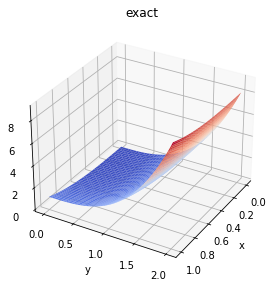

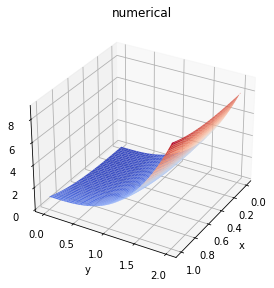

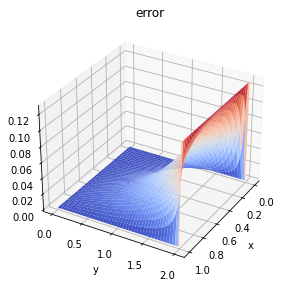

0.1281093940805178


In [24]:
plot_solution(xx,yy,u_ex, txt = "exact")
plt.show()

plot_solution(xx,yy,U, txt = "numerical")
plt.show()

plot_solution(xx,yy,(u_ex-U), txt = "error")
plt.show()

print(np.max(np.abs(u_ex-U)))
#print(np.abs(u_ex-U)[-1,:])

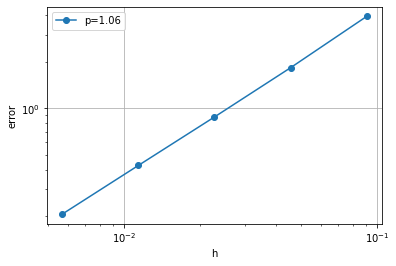

In [13]:
M = 11
a = 2

H, E, p = convergence(f1,g1,M,a, r = np.pi, solver = heat_eq_solver_general)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()

## 2)

In [39]:
def isotropic_heat_solver_fatten(f,g1,g2,g3,M):
    h = 1/M

    r = Symbol('r')

    y = np.linspace(0,1,M+1)
    x = np.linspace(0,1,M+1)
    U = np.zeros((M+1,M+1))

    P = (np.sqrt(1-y[1:-1])//h).astype(int)

    def proj(r,*args):
        xp,yp = args
        return xp+r*(1-2*yp)-2*r**3
    
    def proj_prime(r,*args):
        xp,yp = args
        return 1-2*yp-6*r**2
    
    fatten_bnd_index_i = []
    fatten_bnd_index_j = []

    A = np.zeros((P.sum(),P.sum()))
    bn = np.zeros(P.sum())

    U[:,0] = g2(x[0],y)
    U[0,:] = g1(x,y[0])
    
    for j in range(M-1):
        for i in range(P[j]):
            k = i + P[:j].sum()
            
            A[k,k] = 4
            
            bn[k] = f(x[i+1],y[j+1])*h**2

            if i-1 >= 0:
                A[k,k-1] = -1
            else:
                bn[k] += U[j+1,0]
            
            if x[i+2]**2 < 1-y[j+1]:
                A[k,k+1] = -1
            else:
                rp = sp.optimize.fsolve(proj,x[i+1],args = (x[i+2],y[j+1]), fprime= proj_prime)
                # rp er ikke type float!!!!!!! er et object.
                U[j+1,i+2] = g3(rp,1-rp**2)
                bn[k] += U[j+1,i+2]
                fatten_bnd_index_i.append(i+2)
                fatten_bnd_index_j.append(j+1)
            
            if j - 1 >= 0:
                A[k,k-(P[j-1])] = -1
            else:
                bn[k] += U[0,i+1]
            
            if y[j+2] < 1-x[i+1]**2:
                A[k,k+(P[j])] = -1
            else:
                rp = sp.optimize.fsolve(proj,x[i+1],args = (x[i+1],y[j+2]), fprime= proj_prime)
                U[j+2,i+1] = g3(rp,1-rp**2)
                bn[k] += U[j+2,i+1]
                fatten_bnd_index_i.append(i+1)
                fatten_bnd_index_j.append(j+2)
    
    
    V = sp.sparse.linalg.spsolve(sp.sparse.csr_matrix(A),bn)

    for j in range(M-1):
        for i in range(P[j]):
            k = i + P[:j].sum()

            U[j+1,i+1] = V[k]
    
    return x,y,U, (fatten_bnd_index_j,fatten_bnd_index_i)

In [44]:
"""def g2(x,y):
    return np.cos(x)+np.sin(y)

def f2(x,y):
    return np.cos(x)+np.sin(y)"""

def g2(x,y):
    return -np.cos(3*x)+np.exp(2*y)

def f2(x,y):
    return -9*np.cos(3*x)-4*np.exp(2*y)

In [45]:
x,y,U,bnd_index = isotropic_heat_solver_fatten(f2,g2,g2,g2,M = 200)

xx,yy = np.meshgrid(x,y)
#print(bnd_index)
u_ex = g2(xx,yy)
u_ex[xx**2 > 1-yy] = 0
u_ex[bnd_index] = g2(xx[bnd_index],yy[bnd_index])

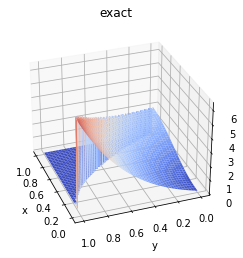

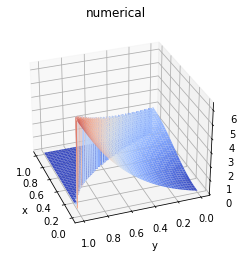

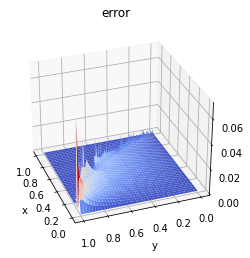

0.07111469574712626


In [46]:
angle = 160
plot_solution(xx,yy,u_ex, txt = "exact", angle=angle)
plt.show()

plot_solution(xx,yy,U, txt = "numerical", angle=angle)
plt.show()

plot_solution(xx,yy,(u_ex-U), txt = "error", angle=angle)
plt.show()


print(np.max(np.abs(U-u_ex)))
#print(np.abs(u_ex-U)[-1,:])

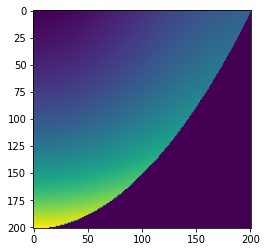

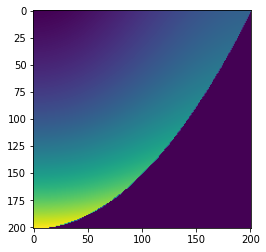

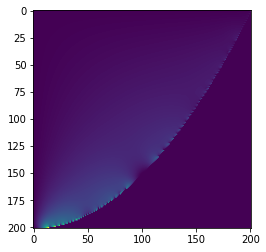

In [47]:
plt.imshow(U)
plt.show()

plt.imshow(u_ex)
plt.show()

plt.imshow(u_ex-U)
plt.show()

In [48]:
def isotropic_heat_solver_modified(f,g1,g2,g3,M):
    h = 1/M

    y = np.linspace(0,1,M+1)
    x = np.linspace(0,1,M+1)
    U = np.zeros((M+1,M+1))

    P = (np.sqrt(1-y[1:-1])//h).astype(int)

    A = np.zeros((P.sum(),P.sum()))
    bn = np.zeros(P.sum())

    U[:,0] = g2(x[0],y)
    U[0,:] = g1(x,y[0])
    
    for j in range(M-1):
        for i in range(P[j]):
            k = i + P[:j].sum()
            
            bn[k] = f(x[i+1],y[j+1])*h**2
            
            nu1 = 1
            nu2 = 1

            if x[i+2]**2 < 1-y[j+1]:
                A[k,k+1] = -1
            elif x[i+2]**2 == 1-y[j+1]:
                bn[k] += g3(x[i+2],y[j+1])
            else:
                x_bnd = np.sqrt(1-y[j+1])
                #print(x_bnd,x[i+1])
                nu1 = (x_bnd-x[i+1])/h
                bn[k] += g3(x_bnd,y[j+1])*2/(nu1*(nu1+1))

            if y[j+2] < 1-x[i+1]**2:
                A[k,k+P[j]] = -1
            elif y[j+1] == 1-x[i+1]**2:
                bn[k] += g3(x[i+1],y[j+2])
            else:
                y_bnd = 1-x[i+1]**2
                #print(y_bnd,y[j+1])
                nu2 = (y_bnd-y[j+1])/h
                bn[k] += g3(x[i+1],y_bnd)*2/(nu2*(nu2+1))
            
            #print(nu1,nu2)

            A[k,k] = 2*(1/nu1+1/nu2)

            if i-1 >= 0:
                A[k,k-1] = -2/(nu1+1)
            else:
                bn[k] += U[j+1,0]*2/(nu1+1)
            
            if j-1 >= 0:
                A[k,k-P[j-1]] = -2/(nu2+1)
            else:
                bn[k] += U[0,i+1]*2/(nu2+1)
    
    V = sp.sparse.linalg.spsolve(sp.sparse.csr_matrix(A),bn)

    for j in range(M-1):
        for i in range(P[j]):
            k = i + P[:j].sum()

            U[j+1,i+1] = V[k]
    
    return x,y,U

In [49]:
x,y,U = isotropic_heat_solver_modified(f2,g2,g2,g2,M = 150)

xx,yy = np.meshgrid(x,y)
u_ex = g2(xx,yy)
u_ex[xx**2 > 1-yy] = 0

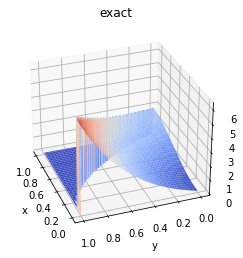

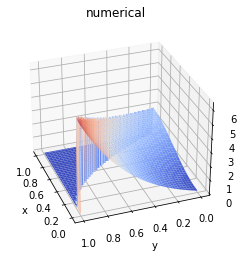

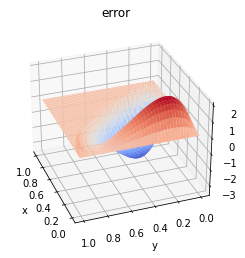

3.5183903919211446e-06


In [50]:
angle = 160
plot_solution(xx,yy,u_ex, txt = "exact", angle=angle)
plt.show()

plot_solution(xx,yy,U, txt = "numerical", angle=angle)
plt.show()

plot_solution(xx,yy,(u_ex-U), txt = "error", angle=angle)
plt.show()


print(np.max(np.abs(U-u_ex)))
#print(np.abs(u_ex-U)[-1,:])